# Sample usage of SnPy
SnPy currently contains two notable classes:
- Perm: a class for permutations
- SnIrrep: a class that acts as a wrapper for producing irreps of permutations

In [2]:
from snpy.perm import Perm, sn
from snpy.sn_irrep import SnIrrep

## The Perm class
We can construct permutations in a few ways:

- `Perm(lst_map)`: the parameter `lst_map` encodes the permutation. To create a permutation $\sigma$ with the standard constructor, you supply a list where each index `i` contains $\sigma(i+1)$. For instance, consider the permutation $$1 \mapsto 2, \quad 2 \mapsto 1, \quad 3 \mapsto 5, \quad 4 \mapsto 3, \quad 5 \mapsto 4$$
is can be constructed as `Perm([2, 1, 5, 3, 4])`
- `Perm.trans(a, b, n)`: the permutation $a \mapsto b, b\mapsto a$ in $\mathbb{S}_n$
- `Perm.cycle(a, b, n)`: creates permutations of the form $a \mapsto a+1, a+1 \mapsto a+2..., b - 1 \mapsto b$
- `Perm.from_cycle_decomp(decomp_lst, n)`: `decomp_lst` is a list of the cycles in the permutation
`Perm.from_cycle_decomp([(1, 2), (3,4)], 4)` constrcuts the permutation: $1 \mapsto 2, 2 \mapsto 1, 3\mapsto 4, 4\mapsto4$ in $\mathbb{S}_n$.
- `Perm.eye(n)`: constructs the identity permutation in `\mathbb{S}_n`

### Useful members of `Perm` objects:
- `Perm.inv()`: returns the inverse permutation
- `Perm.tup`: returns the tuple that encodes the permutation. This may be useful if you need to store a dictionary/set of the permutation signatures. Note that this is a property, not a function
- `Perm.mat()`: returns the $n \times n$ permutation matrix

In [3]:
lst_map = [2, 1, 5, 3, 4]
g = Perm(lst_map)
print('g =', g)
print('Permutation matrix')
print(g.mat())

g = [[1, 2], [3, 5, 4]]
Permutation matrix
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [4]:
# Construct the transposition (1, 5) in S_6
g = Perm.trans(1, 5, 6)

# Construct the transposition (2, 3) in S_6
h = Perm.trans(2, 3, 6)

# Permutations are printed in cycle decomposition
print('g  = ', g)
print('h  = ', h)

# Permutations can be multiplied in the natural way
print('gh = ', g * h)

g  =  [[1, 5]]
h  =  [[2, 3]]
gh =  [[1, 5], [2, 3]]


Permutations can be used as functions or indexed into like dictionaries.

In [5]:
for i in range(1, 6):
    print(f'g[{i}] = {g(i)} = {g[i]}')

g[1] = 5 = 5
g[2] = 2 = 2
g[3] = 3 = 3
g[4] = 4 = 4
g[5] = 1 = 1


In [6]:
# Construct the permutation: (2, 3, 4, 5) in S_7
h = Perm.cycle(2, 5, 6)
print('h:', h)
print('h inverse', h.inv())

h: [[2, 3, 4, 5]]
h inverse [[2, 5, 4, 3]]


In [7]:
# Construct a permutation by supplying its constituent cycles
cycle_decomp = [(1, 2, 3), (4, 7), (5, 6)]
n = 9
g = Perm.from_cycle_decomp(cycle_decomp, n)
print('g: ', g)
print('g inverse:', g.inv())

g:  [[1, 2, 3], [4, 7], [5, 6]]
g inverse: [[1, 3, 2], [4, 7], [5, 6]]


# Constructing Irreps of $\mathbb{S}_n$
`snpy.sn_irrep` contains an `SnIrrep` class that constructs irreps. The `SnIrrep` constructor takes
- partition: tuple of ints denoting the irrep
- fmt: the irrep can be returned as an numpy ndarray/matrix or a [`scipy.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix). You can specify which you want by setting `fmt` to `'dense'` or `'sparse'`

An `SnIrrep` object can then be used a function that takes in a `Perm` object and returns an irrep matrix (in the format specified).

In [8]:
partition = (4, 1)
g = Perm.trans(2, 3, 5)
rho = SnIrrep(partition, fmt='dense')
rho_sp = SnIrrep(partition, fmt='sparse')

print('Dense Representation')
print(rho(g))
print('Sparse representation')
print(rho_sp(g))

Dense Representation
[[ 0.5        0.8660254  0.         0.       ]
 [ 0.8660254 -0.5        0.         0.       ]
 [ 0.         0.         1.         0.       ]
 [ 0.         0.         0.         1.       ]]
Sparse representation
  (0, 1)	0.8660254037844386
  (0, 0)	0.5
  (1, 1)	-0.5
  (1, 0)	0.8660254037844386
  (2, 2)	1.0
  (3, 3)	1.0


### Useful SnIrrep properties:
- `SnIrrep.dim`: the dimension of the irrep
- `SnIrrep.tableaux`: list of the standard young tableaux of the given irrep's shape

In [15]:
shape = (4, 1)
rho = SnIrrep(shape, fmt='sparse')
print(f'Irrep {shape} has dimension: {rho.dim}')
for idx, t in enumerate(rho.tableaux):
    print(f'Index {idx}:')
    print(t)
    print()

Irrep (4, 1) has dimension: 4
Index 0:
[1][3][4][5]
[2]

Index 1:
[1][2][4][5]
[3]

Index 2:
[1][2][3][5]
[4]

Index 3:
[1][2][3][4]
[5]



## A full Fourier transform
Using the Perm and SnIrrep classes, it is relatively straightforward to write a full fourier transform function.

In [8]:
def fourier_transform(f, partition):
    '''
    f: function from Perm to real numbers
    partition: tuple of ints indexing which irrep to fourier transform over
    Returns: numpy matrix
    '''
    n = sum(partition)
    group = sn(n)
    rho = SnIrrep(partition, fmt='dense')

    fhat_rho = 0
    for g in group:
        fhat_rho += f(g) * rho(g)
    return fhat_rho

Let's construct an arbitrary small graph with adjacency matrix $A$ and compute the fourier transform of the resulting graph function: $$f_A (\sigma) = A_{\sigma(n), \sigma(n-1)}$$

In [9]:
import numpy as np
import matplotlib.pyplot as plt

A = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0]
])

def f_adj(sigma):
    '''
    sigma: Perm object
    Returns: 
    '''
    n = A.shape[0]
    return A[sigma(n)-1, sigma(n-1)-1]

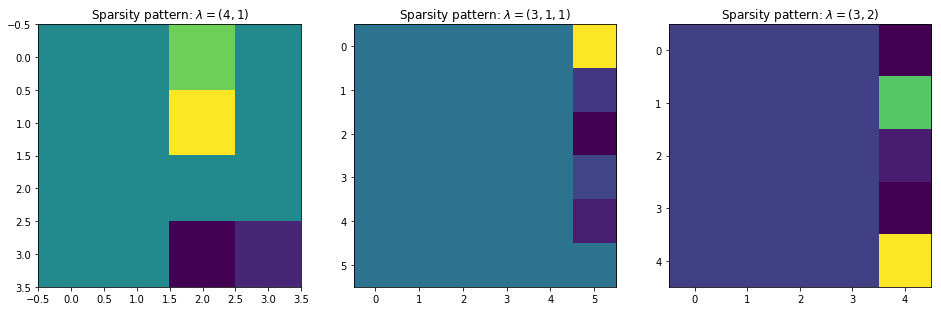

In [10]:
fhat1 = fourier_transform(f_adj, (4, 1))
fhat2 = fourier_transform(f_adj, (3, 1, 1))
fhat3 = fourier_transform(f_adj, (3, 2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(fhat1)
plt.title('Sparsity pattern: $\lambda = (4, 1)$')

plt.subplot(1, 3, 2)
plt.title('Sparsity pattern: $\lambda = (3, 1, 1)$')
plt.imshow(fhat2)

plt.subplot(1, 3, 3)
plt.title('Sparsity pattern: $\lambda = (3, 2)$')
plt.imshow(fhat3)
plt.show()